In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

COLUMNS = ['Date','Total_Cases','New_Daily_Cases','New_Daily_Deaths','Total_Deaths','Total_Recoveries']

In [2]:
import requests
import sys
import csv
import datetime

def generate_csv(code):
    url = "https://thevirustracker.com/free-api?countryTimeline=" + code

    r = requests.get(url, headers={"User-Agent": "XY"})
    data = r.json()
    keys = data['timelineitems'][0].keys()
    length = len(keys)
    name = "covid" + code + ".csv"
    with open(name, 'w', newline='') as file:
                writer = csv.writer(file)
                for key in keys:
                    if length > 1:
                        row = []
                        #x = datetime.datetime.strptime(key, '%m/%d/%y')
                        #xn = x - datetime.timedelta(days=1)
                        #date = xn.strftime("%m/%d/%y")
                        row.append(key)
                        row.append(data['timelineitems'][0][key]['total_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_deaths'])
                        row.append(data['timelineitems'][0][key]['total_deaths'])
                        row.append(data['timelineitems'][0][key]['total_recoveries'])
                        writer.writerow(row)
                        length-=1

In [3]:
def create_dataset(siglas):
    result = pd.DataFrame()
    for i in siglas:
        t = generate_csv(i)
        t_d = pd.read_csv('covid'+i+'.csv')
        tmp = [j+i for j in COLUMNS[1:]]
        tmp.insert(0,'Date')
        t_d.columns = tmp
        t_d.set_index('Date', inplace=True, drop=True)
        result = pd.concat([result,t_d], axis=1, sort=True)    

In [4]:
generate_csv("PT")
generate_csv("IT")

In [54]:
dataIT = pd.read_csv('covidIT.csv')
tmp = [i+"IT" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataIT.columns = tmp
dataIT.set_index('Date', inplace=True, drop=True)
dataIT.tail()
#dataPT.shape
dataPT = pd.read_csv('covidPT.csv')
tmp = [i+"PT" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataPT.columns = tmp
dataPT.set_index('Date', inplace=True, drop=True)
dataPT.tail()
#dataPT.shape

,Total_CasesPT,New_Daily_CasesPT,New_Daily_DeathsPT,Total_DeathsPT,Total_RecoveriesPT
Date,,,,,
4/12/20,16585,598,34,504,5
4/13/20,16934,349,31,535,5
4/14/20,17448,514,32,567,5
4/15/20,18091,643,32,599,5
4/16/20,18841,750,30,629,5


In [76]:
dataPT[['Total_CasesPT']].iloc[-1].index.

Index(['Total_CasesPT'], dtype='object')

In [8]:
def create_dataset_v2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [55]:
from sklearn.preprocessing import MinMaxScaler
values = dataPT[['Total_CasesPT']].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

train_size = int(len(scaled) * 0.85)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

trainX, trainY = create_dataset_v2(train, 5)
testX, testY = create_dataset_v2(test, 5)

print(trainX.shape)
print(testX.shape)
trainX = np.reshape(trainX, (trainX.shape[0], 5, 1))
testX = np.reshape(testX, (testX.shape[0], 5, 1))

n_batch = trainX.shape[0]
print(n_batch)

36 7
(31, 5)
(2, 5)
31


In [94]:
print(scaler.inverse_transform(trainY[-1].reshape(1,-1)))

[[16585.]]


In [13]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model_ls = Sequential()
model_ls.add(LSTM(24,return_sequences=True, batch_input_shape=(n_batch,trainX.shape[1],trainX.shape[2]), stateful=True))
model_ls.add(Dropout(0.2))
model_ls.add(LSTM(24, stateful=True))
model_ls.add(Dropout(0.5))
model_ls.add(Dense(1, activation='linear'))
model_ls.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = []

for i in range(500):
    f = model_ls.fit(trainX, trainY, epochs=1, batch_size=n_batch, shuffle=False)
    history.append(f.history['loss'])
    model_ls.reset_states()

Train on 31 samples
31/31 [==============================] - 2s 53ms/sample - loss: 0.2462 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 248us/sample - loss: 0.2383 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 261us/sample - loss: 0.2241 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 268us/sample - loss: 0.2182 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 250us/sample - loss: 0.2144 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 229us/sample - loss: 0.2163 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 250us/sample - loss: 0.2122 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 242us/sample - loss: 0.2067 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 257us/sample - lo

Train on 31 samples
31/31 [==============================] - 0s 245us/sample - loss: 0.0521 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 243us/sample - loss: 0.0579 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 263us/sample - loss: 0.0465 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 238us/sample - loss: 0.0652 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 258us/sample - loss: 0.0655 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 252us/sample - loss: 0.0699 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 232us/sample - loss: 0.0506 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 256us/sample - loss: 0.0615 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 232us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 271us/sample - loss: 0.0693 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 241us/sample - loss: 0.0420 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 237us/sample - loss: 0.0426 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 251us/sample - loss: 0.0464 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 240us/sample - loss: 0.0407 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 246us/sample - loss: 0.0400 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 232us/sample - loss: 0.0491 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 235us/sample - loss: 0.0559 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 243us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 231us/sample - loss: 0.0438 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 261us/sample - loss: 0.0417 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0356 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 228us/sample - loss: 0.0346 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 273us/sample - loss: 0.0439 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 261us/sample - loss: 0.0510 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 260us/sample - loss: 0.0648 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 238us/sample - loss: 0.0498 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 254us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0467 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 268us/sample - loss: 0.0307 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 241us/sample - loss: 0.0452 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 247us/sample - loss: 0.0373 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0352 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 272us/sample - loss: 0.0357 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 256us/sample - loss: 0.0370 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 268us/sample - loss: 0.0536 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 257us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 250us/sample - loss: 0.0342 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 253us/sample - loss: 0.0331 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 249us/sample - loss: 0.0436 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 233us/sample - loss: 0.0342 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0364 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 236us/sample - loss: 0.0270 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 260us/sample - loss: 0.0338 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 230us/sample - loss: 0.0330 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 280us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 254us/sample - loss: 0.0432 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 306us/sample - loss: 0.0554 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 270us/sample - loss: 0.0233 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 281us/sample - loss: 0.0414 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 239us/sample - loss: 0.0346 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 260us/sample - loss: 0.0520 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 243us/sample - loss: 0.0346 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 258us/sample - loss: 0.0308 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 253us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 256us/sample - loss: 0.0426 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 250us/sample - loss: 0.0432 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 251us/sample - loss: 0.0349 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 243us/sample - loss: 0.0303 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 243us/sample - loss: 0.0272 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 242us/sample - loss: 0.0315 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 245us/sample - loss: 0.0311 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 242us/sample - loss: 0.0360 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 232us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 285us/sample - loss: 0.0348 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 235us/sample - loss: 0.0315 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 223us/sample - loss: 0.0317 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 238us/sample - loss: 0.0349 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 257us/sample - loss: 0.0472 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 244us/sample - loss: 0.0362 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0413 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 260us/sample - loss: 0.0379 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 222us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 247us/sample - loss: 0.0360 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 244us/sample - loss: 0.0420 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 290us/sample - loss: 0.0356 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 269us/sample - loss: 0.0378 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 246us/sample - loss: 0.0431 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 308us/sample - loss: 0.0307 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0379 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 254us/sample - loss: 0.0324 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 240us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 251us/sample - loss: 0.0362 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 243us/sample - loss: 0.0392 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 246us/sample - loss: 0.0359 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 255us/sample - loss: 0.0338 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 259us/sample - loss: 0.0422 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 234us/sample - loss: 0.0382 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 229us/sample - loss: 0.0302 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 229us/sample - loss: 0.0400 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 254us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 248us/sample - loss: 0.0435 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 258us/sample - loss: 0.0343 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 231us/sample - loss: 0.0342 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 237us/sample - loss: 0.0407 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 235us/sample - loss: 0.0313 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 237us/sample - loss: 0.0368 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 236us/sample - loss: 0.0435 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 254us/sample - loss: 0.0384 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 232us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 244us/sample - loss: 0.0380 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 242us/sample - loss: 0.0391 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 241us/sample - loss: 0.0361 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 235us/sample - loss: 0.0395 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 249us/sample - loss: 0.0490 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 270us/sample - loss: 0.0381 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 305us/sample - loss: 0.0343 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 231us/sample - loss: 0.0309 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 275us/sample - l

Train on 31 samples
31/31 [==============================] - 0s 236us/sample - loss: 0.0392 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 284us/sample - loss: 0.0482 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 265us/sample - loss: 0.0311 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 422us/sample - loss: 0.0390 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 260us/sample - loss: 0.0358 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 227us/sample - loss: 0.0312 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 239us/sample - loss: 0.0435 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 239us/sample - loss: 0.0412 - accuracy: 0.0000e+00
Train on 31 samples
31/31 [==============================] - 0s 298us/sample - l

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_ls = Sequential()
model_ls.add(LSTM(256,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2])))
model_ls.add(Dropout(0.2))
model_ls.add(LSTM(256, return_sequences=True))
model_ls.add(Dropout(0.2))
model_ls.add(LSTM(256))
model_ls.add(Dropout(0.5))
model_ls.add(Dense(1, activation='linear'))
model_ls.compile(loss='mean_absolute_error', optimizer='sgd')

history = model_ls.fit(trainX, trainY, epochs=2500, batch_size=32, verbose=0, shuffle=False, validation_data=(testX,testY))

[[20459.3  ]
 [20481.184]] [[18091. 18841.]]


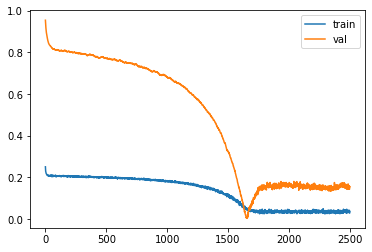

In [91]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

results = model_pred.predict(testX)
print(scaler.inverse_transform(results),scaler.inverse_transform(testY.reshape(1,-1)))

In [61]:
model_pred = Sequential()
model_pred.add(LSTM(24,return_sequences=True, batch_input_shape=(1,trainX.shape[1],trainX.shape[2]), stateful=True))
model_pred.add(Dropout(0.2))
model_pred.add(LSTM(24, stateful=True))
model_pred.add(Dropout(0.5))
model_pred.add(Dense(1, activation='linear'))

model_pred.set_weights(model_ls.get_weights())
model_pred.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

#for i in range(len(testX)):
    #tx = testX[i].reshape(1, 1, 5)
results = model_pred.predict(testX, batch_size=1)
print(scaler.inverse_transform(results),scaler.inverse_transform(testY.reshape(1,-1)))


[[15523.213]
 [19946.182]] [[18091. 18841.]]


In [30]:
prediction = model_ls.predict(testX)
print(scaler.inverse_transform(prediction))
print(scaler.inverse_transform(testY.reshape(1,-1)))

[[15378.593]
 [15915.588]
 [16513.477]]
[[15472. 15987. 16585.]]


In [65]:
def predict(model, days, dataset):
    data = dataset[-1]
    results = []
    for i in range(days):
        prediction = model.predict(data.reshape(1,5,1))
        value = scaler.inverse_transform(prediction)
        data = data[1:]
        data = np.append(data,np.array(value))
        results.append(value)
    print(results)

In [71]:
print(testX)
np.append(testX[-1][1:],np.array(5)).reshape(1,5,1)
print(scaler.inverse_transform(testX[-1]))

[[[0.6799156 ]
  [0.70717734]
  [0.7501207 ]
  [0.7922799 ]
  [0.8414355 ]]

 [[0.70717734]
  [0.7501207 ]
  [0.7922799 ]
  [0.8414355 ]
  [0.932871  ]]

 [[0.7501207 ]
  [0.7922799 ]
  [0.8414355 ]
  [0.932871  ]
  [0.9639325 ]]]
[[12442.]
 [13141.]
 [13956.]
 [15472.]
 [15987.]]


In [66]:
predict(model_ls, 2, testX)

[array([[16513.477]], dtype=float32), array([[18576.277]], dtype=float32)]


In [94]:
t = np.array([0.80804247, 0.8404416,  0.89147735, 0.9415813,  1.0000001 ])
t.reshape(1,5,1)

array([[[0.80804247],
        [0.8404416 ],
        [0.89147735],
        [0.9415813 ],
        [1.0000001 ]]])

In [95]:
t = np.array([[0.00179199],
 [0.00179199],
 [0.00258046],
 [0.00387069],
 [0.00387069]])
t.reshape(1,5,1)

array([[[0.00179199],
        [0.00179199],
        [0.00258046],
        [0.00387069],
        [0.00387069]]])